In [1]:
!pip install tensorflow

^C


In [3]:
from numpy.random import seed
seed(888)
import tensorflow as tf

In [4]:
random_seed = tf.random.set_seed(404)
random_seed

In [5]:
import os
import numpy as np
import tensorflow as tf
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Activation

from IPython.display import display
from keras.preprocessing.image import array_to_img
from keras.callbacks import TensorBoard

from time import strftime

import matplotlib.pyplot as plt

%matplotlib inline

In [57]:
LOG_DIR = 'tensorboard_cifar_logs/'

LABEL_NAMES = ['Plane','Car','Bird','Cat','Deer', 'Dog','Frog','Horse', 'Ship','Truck']
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
IMAGE_PIXELS = IMAGE_WIDTH * IMAGE_HEIGHT
COLOR_CHANNELS = 3
TOTAL_INPUTS = IMAGE_PIXELS * COLOR_CHANNELS
NR_CLASSES = 10

VALIDATION_SIZE = 10000
SMALL_TRAIN_SIZE = 1000

# Explore the Data

In [58]:
(x_train_all, y_train_all), (x_test, y_test) = cifar10.load_data()

In [59]:
type(cifar10)
type(x_train_all)

numpy.ndarray

In [60]:
x_train_all[0]

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

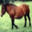

In [61]:
pic = array_to_img(x_train_all[7])
display(pic)

In [62]:
y_train_all.shape

(50000, 1)

In [63]:
y_train_all[7][0]

7

In [64]:
LABEL_NAMES[y_train_all[7][0]]

'Horse'

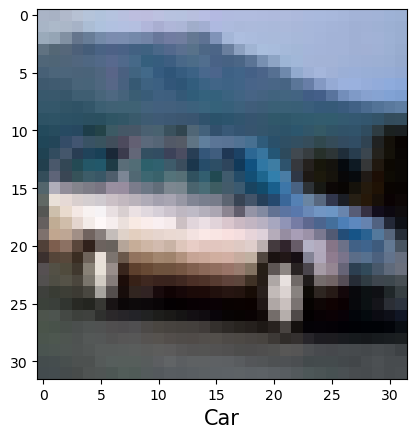

In [65]:
plt.imshow(x_train_all[4])
plt.xlabel(LABEL_NAMES[y_train_all[4][0]], fontsize=15)
plt.show()

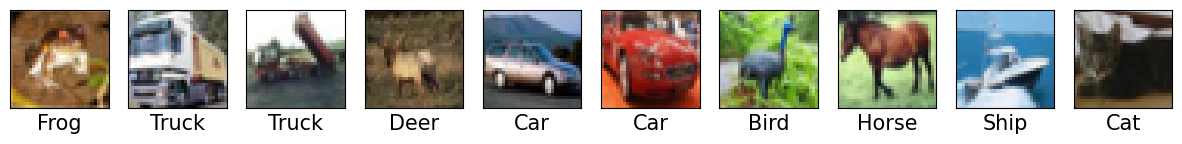

In [66]:
plt.figure(figsize=(15,5))

for i in range(10):
  plt.subplot(1,10,i+1)
  plt.yticks([])
  plt.xticks([])
  plt.xlabel(LABEL_NAMES[y_train_all[i][0]], fontsize=15)
  plt.imshow(x_train_all[i])

In [67]:
x_train_all[0].shape

(32, 32, 3)

In [68]:
no_images, x, y, c = x_train_all.shape
print(f"images = {no_images} \t | width = {x} \t | height = {y} \t | channels = {c}")

images = 50000 	 | width = 32 	 | height = 32 	 | channels = 3


In [69]:
x_test.shape

(10000, 32, 32, 3)

# Preprocess Data

In [70]:
type(x_train_all[0][0][0][0])

numpy.uint8

In [71]:
x_train_all, x_test = x_train_all / 255.0 , x_test / 255.0

In [72]:
x_train_all[0][0][0][0]

0.23137254901960785

In [73]:
x_train_all = x_train_all.reshape(x_train_all.shape[0], TOTAL_INPUTS)

In [74]:
x_train_all.shape

(50000, 3072)

In [75]:
x_test = x_test.reshape(len(x_test), TOTAL_INPUTS)
print(f"Shape of x_test is {x_test.shape}")

Shape of x_test is (10000, 3072)


# Creating Validation Dataset

In [76]:
x_val = x_train_all[:VALIDATION_SIZE]
y_val = y_train_all[:VALIDATION_SIZE]
x_val.shape

(10000, 3072)

In [77]:
x_train = x_train_all[VALIDATION_SIZE:]
y_train = y_train_all[VALIDATION_SIZE:]
x_train.shape

(40000, 3072)

For Illustration

In [78]:
x_train_xs = x_train[:SMALL_TRAIN_SIZE]
y_train_xs = y_train[:SMALL_TRAIN_SIZE]

Neural Network

In [79]:
model_1 = Sequential([
    Dense(units=128, input_dim=TOTAL_INPUTS, activation='relu', name='m1_hidden1'),
    Dense(units=64, activation='relu',name='m1_hidden2'),
    Dense(16, activation='relu',name='m1_hidden3'),
    Dense(10, activation='softmax',name='m1_output')
])

model_1.compile(
optimizer= keras.optimizers.Adam(),
loss= keras.losses.SparseCategoricalCrossentropy(from_logits= True),
metrics= ['accuracy'])

In [80]:
type(model_1)

keras.src.engine.sequential.Sequential

In [81]:
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 m1_hidden1 (Dense)          (None, 128)               393344    
                                                                 
 m1_hidden2 (Dense)          (None, 64)                8256      
                                                                 
 m1_hidden3 (Dense)          (None, 16)                1040      
                                                                 
 m1_output (Dense)           (None, 10)                170       
                                                                 
Total params: 402810 (1.54 MB)
Trainable params: 402810 (1.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Tensorboard (Visualising Learning)

In [82]:
def get_tensorboard(model_name):
    log_dir = "logs/fit/" + model_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    return tensorboard_callback


## Model Fit

In [83]:
sample_per_batch = 1000

In [84]:
%%time

nr_epochs = 150

model_1.fit(x_train_xs, y_train_xs,batch_size=sample_per_batch,epochs=nr_epochs ,callbacks=[get_tensorboard('Model 1')])

Epoch 1/20


C:\Users\shubh\anaconda3\Lib\site-packages\keras\src\backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1/1 [==============================] - 1s 784ms/step - loss: 2.3264 - accuracy: 0.1170
Epoch 2/20
1/1 [==============================] - 0s 112ms/step - loss: 2.3429 - accuracy: 0.1030
Epoch 3/20
1/1 [==============================] - 0s 109ms/step - loss: 2.3029 - accuracy: 0.1780
Epoch 4/20
1/1 [==============================] - 0s 113ms/step - loss: 2.3279 - accuracy: 0.0890
Epoch 5/20
1/1 [==============================] - 0s 100ms/step - loss: 2.2765 - accuracy: 0.1150
Epoch 6/20
1/1 [==============================] - 0s 94ms/step - loss: 2.2795 - accuracy: 0.1500
Epoch 7/20
1/1 [==============================] - 0s 100ms/step - loss: 2.2599 - accuracy: 0.1440
Epoch 8/20
1/1 [==============================] - 0s 99ms/step - loss: 2.2438 - accuracy: 0.1760
Epoch 9/20
1/1 [==============================] - 0s 102ms/step - loss: 2.2543 - accuracy: 0.1510
Epoch 10/20
1/1 [==============================] - 0s 97ms/step - loss: 2.2352 - accuracy: 0.1400
Epoch 11/20
1/1 [================